# Преобразование 2D-изображения

In [1]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

Пользовательские функции:

In [2]:
from Functions.combine_matrices import combine_matrices
from Functions.split_matrices import split_matrices

## Импорт изображения из файла

In [3]:
from PIL import Image
# Load a BMP image
image_path = 'images/couple.bmp'
img = Image.open(image_path)

# Display basic information about the image
print(f"Image Format: {img.format}")
print(f"Image Size: {img.size}")
print(f"Image Mode: {img.mode}")

Image Format: BMP
Image Size: (512, 512)
Image Mode: L


Total Energy (Signal) 66858.44


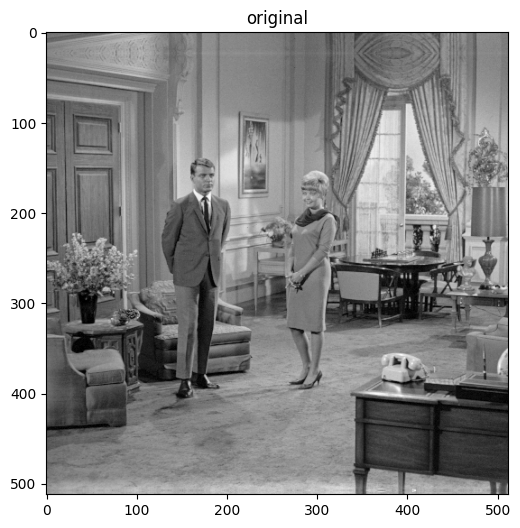

In [4]:
f = (np.matrix(img) / 255).astype(float)
[Nrow, Ncol] = np.shape(f)

print('Total Energy (Signal)', np.round(np.sum(np.array(f)**2),2))

plt.figure(figsize=(6,6))
plt.imshow(f, cmap='gray')
plt.title('original')
plt.savefig('readme_img/original.png', bbox_inches='tight')
plt.show()

## Преобразование 'db1'

### Прямое преобразование

In [5]:
# Number of levels.
K = 4
# Wavelet type.
wavelet = 'db1'

coeff = np.empty(K, dtype='object')
for k in range(K):
    if k == 0:
        coeff[k] = f.copy()
    else:
        coeff[k] = coeff[k-1].copy()
    cA, (cH, cV, cD) = pywt.dwt2(coeff[k][:Nrow//2**k,:Ncol//2**k], wavelet)
    coeff[k][:Nrow//2**k,:Ncol//2**k] = combine_matrices(cA, cH, cV, cD)

In [6]:
user_fontsize = 14

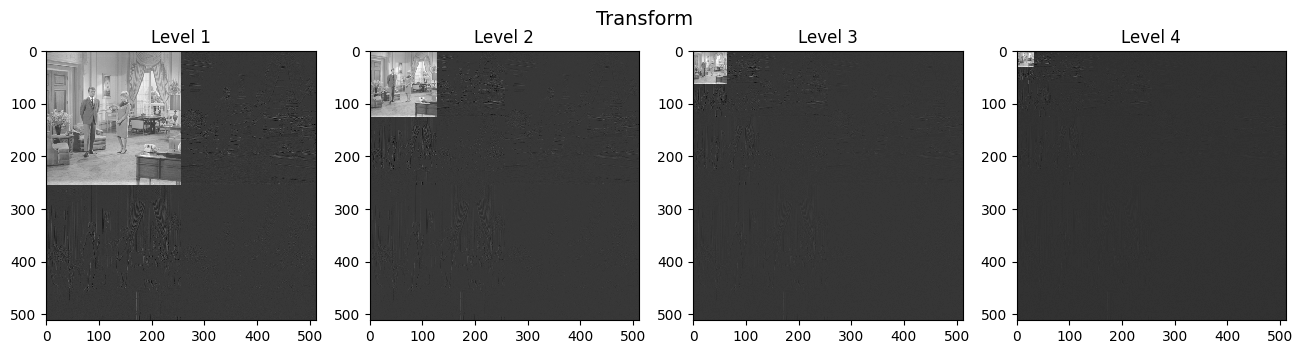

In [7]:
fig, axs = plt.subplots(ncols=K, nrows=1, figsize=(4*K, 4))
for k, ax in enumerate(axs.flat):
    ax.imshow(coeff[k], cmap='gray', interpolation='none')
    ax.set_title('Level ' + str(k + 1))
plt.text(-200*K, -50, 'Transform', fontsize=user_fontsize)
plt.savefig('readme_img/transform.png', bbox_inches='tight')
plt.show()

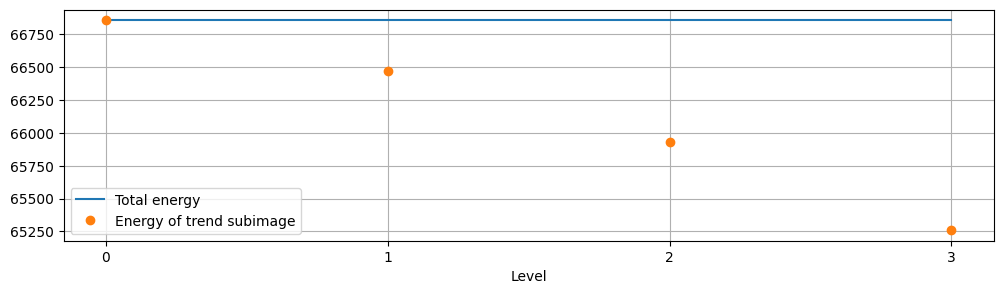

In [8]:
full_energy = []
trend_energy = []
for k in range(K):
    full_energy.append(np.sum(np.array(coeff[k])**2))
    trend_energy.append(np.sum(np.array(coeff[k][:Nrow//2**k,:Ncol//2**k])**2))

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(12)
ax.plot(full_energy, label='Total energy')
ax.plot(trend_energy, 'o', label='Energy of trend subimage')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Level')
plt.grid(True)
plt.legend()
plt.savefig('readme_img/energy_pywt.png', bbox_inches='tight')
plt.show()

### Обратное преобразование

In [9]:
f_rec = np.empty(K, dtype='object')

for k in reversed(range(K)):
    f_rec[k] = coeff[k].copy()
    cA, (cH, cV, cD) = split_matrices(coeff[k][:Nrow//2**k,:Ncol//2**k])
    f_rec[k][:Nrow//2**k,:Ncol//2**k] = pywt.idwt2((cA, (cH, cV, cD)), wavelet)

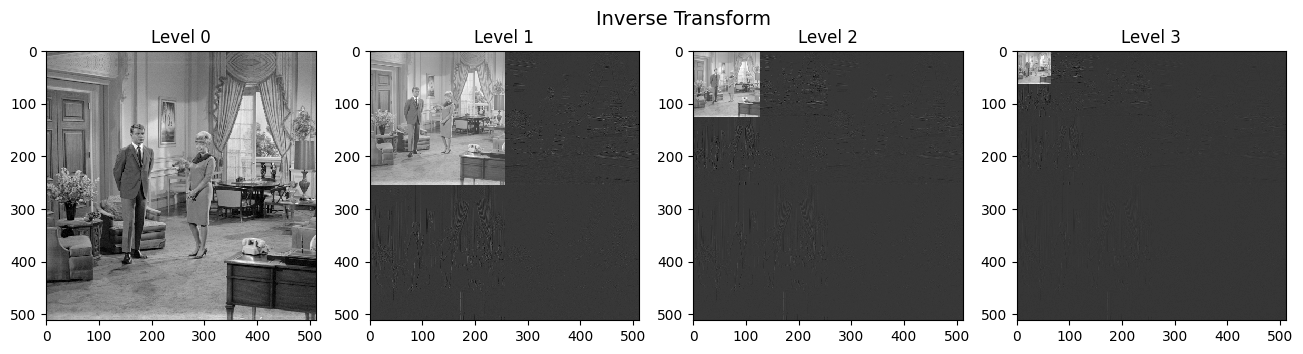

In [10]:
fig, axs = plt.subplots(ncols=K, nrows=1, figsize=(4*K, 4))
for k, ax in enumerate(axs.flat):
    ax.imshow(f_rec[k], cmap='gray', interpolation='none')
    ax.set_title('Level ' + str(k))
plt.text(-200*K, -50, 'Inverse Transform', fontsize=user_fontsize)
plt.savefig('readme_img/reconstruction.png', bbox_inches='tight')
plt.show()

Difference (sum squared): 2.1284511178380237e-24


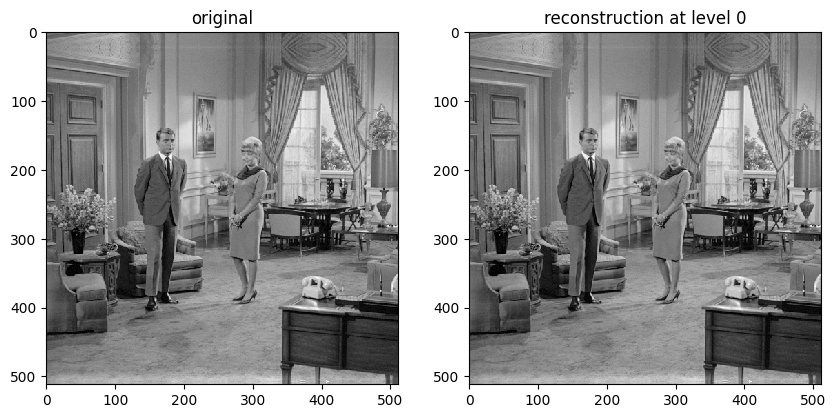

In [11]:
print('Difference (sum squared):', np.sum( (f-f_rec[0])**2 ))
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(f, cmap='gray', interpolation='none')
axs.flat[0].set_title('original')
axs.flat[1].imshow(f_rec[0], cmap='gray', interpolation='none')
axs.flat[1].set_title('reconstruction at level 0')
plt.savefig('readme_img/comparison.png', bbox_inches='tight')
plt.show()

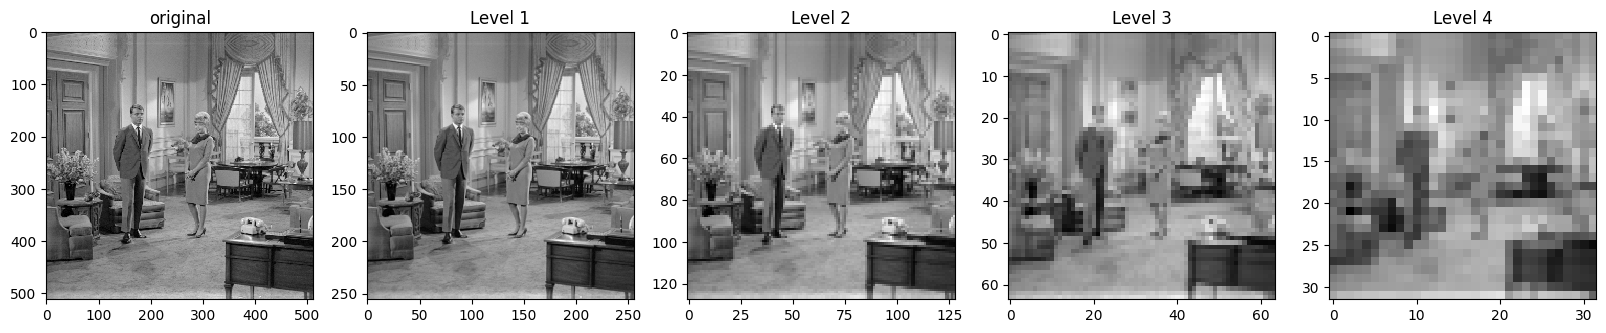

In [12]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(f, cmap='gray', interpolation='none')
        ax.set_title('original')
    else:    
        ax.imshow(coeff[k-1][:Nrow//2**k,:Ncol//2**k], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
plt.savefig('readme_img/trends.png', bbox_inches='tight')
plt.show()